<a href="https://colab.research.google.com/github/loulyp/Nighttime-Pothole-Detection-/blob/main/Nighttime_Pothole_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ARTI 404 - Image Processing  : Nighttime Pothole Detection Using Image Processing and deep learning Techniques  

# Import the needed libraries

In [ ]:
import zipfile
import os
import random
import shutil
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure


# **taking a sample of 2000 image for Preprocessing**

In [ ]:
# run this and upload the data set zip file (NPD.zip)
from google.colab import files
uploaded = files.upload()

Saving NPD.zip to NPD.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile("NPD.zip", 'r') as zip_ref:
    zip_ref.extractall("NPD")  # extract to a folder


In [ ]:
import os
import random
import shutil
import json


extract_dir = 'NPD/NPD'
sample_dir = 'sample_2000'
num_samples = 2000  # how many images to sample
random.seed(42)  # reproducibility

#Collect All Images
image_dirs = [os.path.join(extract_dir, subdir) for subdir in ['train', 'valid', 'test']]
all_images = []


for folder in image_dirs:
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_images.append(os.path.join(folder, file))


# Random Sampling
sample_images = random.sample(all_images, num_samples)


# Copy Sampled Images
os.makedirs(os.path.join(sample_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(sample_dir, 'annotations'), exist_ok=True)

sample_image_names = []  # to save the filenames
for img_path in sample_images:
    img_name = os.path.basename(img_path)
    sample_image_names.append(img_name)
    shutil.copy(img_path, os.path.join(sample_dir, 'images', img_name))



# Filter Annotations
# Load annotations
annotations_path = os.path.join(extract_dir, 'annotations')
coco_files = ['instances_train.json', 'instances_valid.json', 'instances_test.json']

all_annotations = {
    "images": [],
    "annotations": [],
    "categories": []
}

# Keep track of IDs
new_image_id = 1
new_ann_id = 1
filename_to_new_id = {}

for coco_file in coco_files:
    coco_path = os.path.join(annotations_path, coco_file)
    if not os.path.exists(coco_path):
        continue

    with open(coco_path, 'r') as f:
        coco_data = json.load(f)

    if not all_annotations["categories"]:
        all_annotations["categories"] = coco_data["categories"]

    # Go through images
    image_id_to_filename = {img["id"]: img["file_name"] for img in coco_data["images"]}

    # Filter images
    selected_image_ids = []
    for img in coco_data["images"]:
        if img["file_name"] in sample_image_names:
            new_img = img.copy()
            new_img["id"] = new_image_id
            filename_to_new_id[img["file_name"]] = new_image_id
            all_annotations["images"].append(new_img)
            selected_image_ids.append(img["id"])
            new_image_id += 1

    # Filter annotations
    for ann in coco_data["annotations"]:
        if ann["image_id"] in selected_image_ids:
            new_ann = ann.copy()
            old_img_id = ann["image_id"]
            new_ann["id"] = new_ann_id
            new_ann["image_id"] = filename_to_new_id[image_id_to_filename[old_img_id]]
            all_annotations["annotations"].append(new_ann)
            new_ann_id += 1


# Save Annotations
out_path = os.path.join(sample_dir, 'annotations', 'instances_sampled.json')
with open(out_path, 'w') as f:
    json.dump(all_annotations, f)


print("✅ Sample of 2000 images and annotations copied."


✅ Sample of 2000 images and annotations copied.


note: every time you run this code you'll get different image

# **Applying Image Processing Techniques**

In [ ]:
def showGrayImage(img, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()

def showRGBImage(img, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()

### Select a random image and convert it into gray scaled

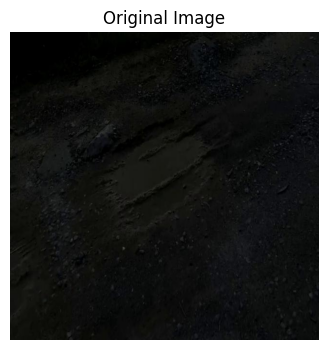

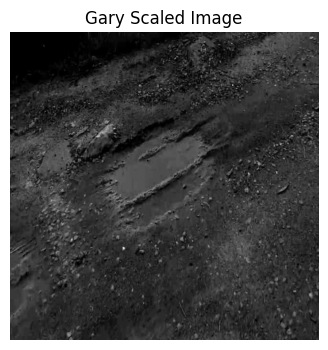

In [ ]:
# Path to sample images
input_folder = 'sample_2000/images'

# Pick a random image
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random_image = random.choice(image_files)
img_path = os.path.join(input_folder, random_image)

# Load the image
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

# === Show the images ===
showRGBImage(img_rgb, 'Original Image')

# Convert it into Gray scaled
gray_image = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
showGrayImage(gray_image, 'Gary Scaled Image')

### Perform Log Transformation with adding a small epsilon to avoid log(0)

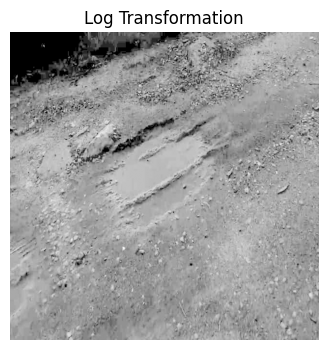

In [ ]:
c = 30
epsilon = 1e-8
log_transformed_float = c * np.log(gray_image + 1 + epsilon)
normalized_log = cv2.normalize(log_transformed_float, None, 0, 255, cv2.NORM_MINMAX) # Normalize the pixel values to the range 0-255
log_transformed = np.uint8(normalized_log) # Convert to uint8

showGrayImage(log_transformed, 'Log Transformation')

### Sharpen image using Laplacian filter

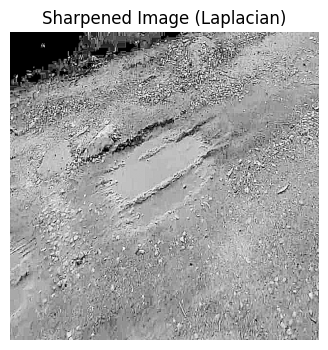

In [ ]:
image_float = log_transformed.astype(np.float32) / 255.0
laplacian= cv2.Laplacian(image_float , cv2.CV_32F, ksize=3)
sharpened = np.clip(image_float - 0.5 *laplacian, 0, 1)

showGrayImage(sharpened, 'Sharpened Image (Laplacian)')

### Median Noise Reduction

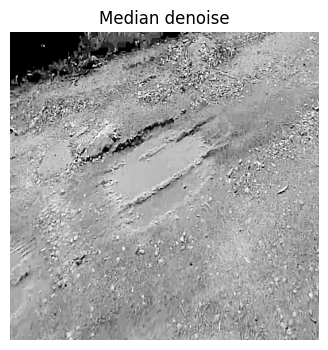

In [ ]:
final = cv2.medianBlur((sharpened * 255).astype(np.uint8), 3)  # Use kernel size 3
showGrayImage(final, 'Median denoise')

### Contrast stretching to Rescale intensity

---

values to include the intensities within the 3rd and 100th percentiles

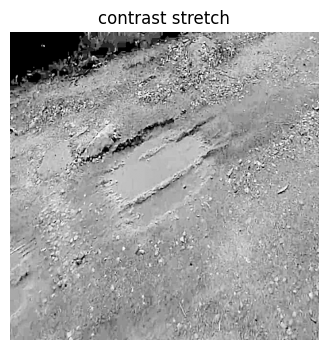

In [ ]:
p3, p100 = np.percentile(final, (3, 100))
contrast = exposure.rescale_intensity(final, in_range=(p3, p100))
showGrayImage(contrast, 'contrast stretch')

### Overlayering the result


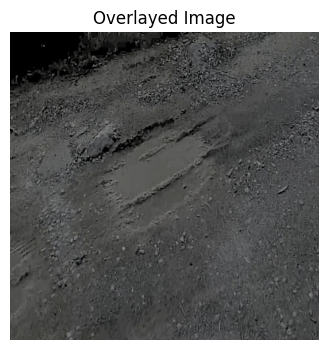

In [ ]:
# Resize preprocessed image to match original
resized_prep = cv2.resize(contrast, (img.shape[1], img.shape[0]))

# Ensure both are 3-channel (for blending)
if len(resized_prep.shape) == 2:
    resized_prep = cv2.cvtColor(resized_prep.astype(np.uint8), cv2.COLOR_GRAY2RGB)

# Blend (adjust alpha for effect)
overlay = cv2.addWeighted(img_rgb, 0.6, resized_prep, 0.4, 0)
showRGBImage(overlay,"Overlayed Image")



### Print the results

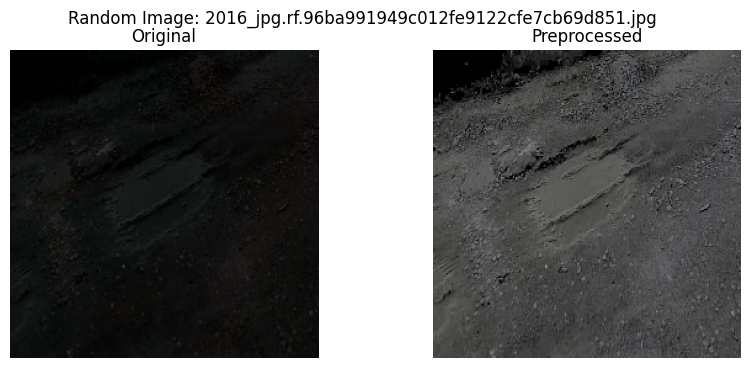

In [ ]:
resized_Org = cv2.resize(img, (250, 250))
resized_prs = cv2.resize(overlay, (250, 250))

# === Show the images ===
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(resized_Org,cmap = 'gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Preprocessed")
plt.imshow(resized_prs,cmap = 'gray')
plt.axis("off")

plt.suptitle(f"Random Image: {random_image}")
plt.show()

### Compare the Histogram of Both images

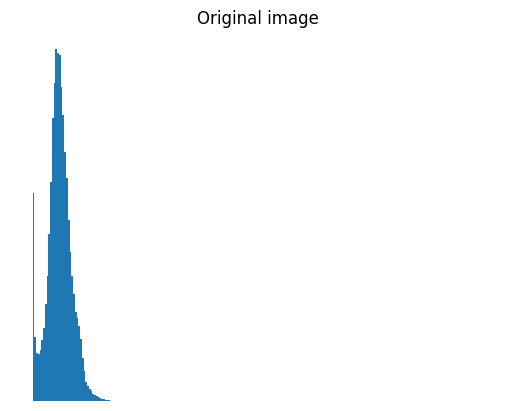

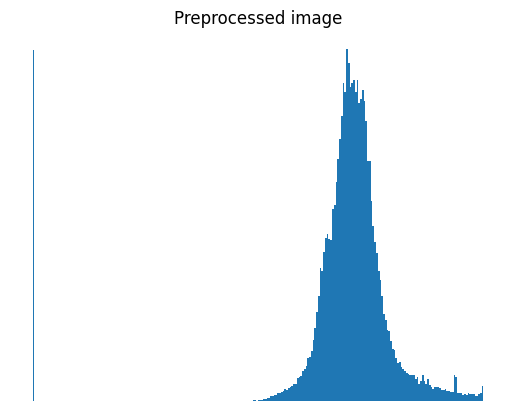

In [ ]:
#original image histogram
plt.axis('off')
plt.title('Original image')
plt.hist(resized_Org.flat, bins = 256, range=(0, 255))
plt.xlabel('level values')
plt.ylabel('Number of pixels')
plt.show()


#new image histogram
resized_prs = (resized_prs * 255).astype(np.uint8)
plt.axis('off')
plt.title('Preprocessed image')
plt.hist(resized_prs.flat, bins = 256, range=(0, 255))
plt.xlabel('level values')
plt.ylabel('Number of pixels')
plt.show()

## **preprocessing on the entire sample**

In [ ]:
import os
import cv2

# Paths
input_folder = 'sample_2000/images'
output_folder = 'sample_2000/processed_images'
os.makedirs(output_folder, exist_ok=True)

# Loop through all images
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray_image = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

        c = 30
        epsilon = 1e-8
        log_transformed_float = c * np.log(gray_image + 1 + epsilon)
        normalized_log = cv2.normalize(log_transformed_float, None, 0, 255, cv2.NORM_MINMAX)
        log_transformed = np.uint8(normalized_log)

        image_float = log_transformed.astype(np.float32) / 255.0
        laplacian= cv2.Laplacian(image_float , cv2.CV_32F, ksize=3)
        sharpened = np.clip(image_float - 0.5 *laplacian, 0, 1)

        final = cv2.medianBlur((sharpened * 255).astype(np.uint8), 3)

        p3, p100 = np.percentile(final, (3, 100))
        contrast = exposure.rescale_intensity(final, in_range=(p3, p100))

        resized_prep = cv2.resize(contrast, (img.shape[1], img.shape[0]))

        if len(resized_prep.shape) == 2:
            resized_prep = cv2.cvtColor(resized_prep.astype(np.uint8), cv2.COLOR_GRAY2RGB)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        overlay = cv2.addWeighted(img_rgb, 0.6, resized_prep, 0.4, 0)

        # Save processed image
        out_path = os.path.join(output_folder, filename)
        cv2.imwrite(out_path, overlay)

print("✅ Preprocessing complete. Processed images saved to:", output_folder)

✅ Preprocessing complete. Processed images saved to: sample_2000/processed_images


After completing the preprocessing of all images and saving the results, we will proceed to split the dataset into training, validation, and test sets using Roboflow. Once the split is done, the prepared data will be used to train the model.